y0 - A1.d
y1 - A1.d
y2 - A1.d
y3 - A2.d
y4 - A2.d
y5 - A2.d
y6 - B1.d
y7 - B1.d
y8 - B1.d
y9 - B2.d
y10 - B2.d
y11 - B2.d
y12 - C1.d
y13 - C1.d
y14 - C1.d
y15 - C2.d
y16 - C2.d
y17 - C2.d
y18 - D1.d
y19 - D1.d
y20 - D1.d
y21 - D2.d
y22 - D2.d
y23 - D2.d
y24 - E1.d
y25 - E1.d
y26 - E1.d
y27 - E2.d
y28 - E2.d
y29 - E2.d
y30 - no_inj_1.d
y31 - no_inj_1.d
y32 - no_inj_1.d
y33 - no_inj_2.d
y34 - no_inj_2.d
y35 - no_inj_2.d


/Users/ryancardiff/opt/anaconda3/envs/ODBM/lib/python3.7/site-packages/ipykernel_launcher.py:93: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


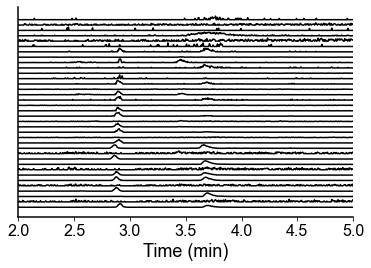

In [2]:

import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import os
import itertools
import re
import sys
import csv
from plot_params import *

########################################################
#Clustio - A python based comparative genomics toolbox
#Usage: python clustio.py inputfile.txt, outputfile.txt
#Last updated: 06/20/21
#Created by: Dr. Jorge Marchand
#Uses cblaster https://github.com/gamcil/cblaster
#API Key - 0a9bb9813c2a22602c6924fd8764042e8808
#cblaster config --api_key 0a9bb9813c2a22602c6924fd8764042e8808
########################################################


def pad(l, content, width):
    l.extend([content] * (width - len(l)))
    return l
    
    
def raw2df(input_file):
    #dat=pd.read_csv(input_file, header = None, sep = ',')
    #for i in range(0,len(dat)):

    with open(input_file, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
    
    y=[]
    x=[]
    y_n = 0
    for i in range (0,len(data)):
        if 'ESI' in data[i][0]:
            s = data[i][0]
            sample_name = re.search('V (.*).d', s)

            if print_sname == True: #Prints the sample name to console
                print('y'+str(y_n)+' - '+sample_name[0][2:])
            
            y_n=y_n+1 #y name
            if y_n==2: #Create dataframe after the first set
                wf_data = pd.DataFrame(data=x, columns = ['time'])
            
            
            #Append data count column
            if y_n>=2:  #Append data count column
                if len(y)<len(wf_data):
                    za=[0]*(len(wf_data)-len(y)) #Zeros to add
                    y=y+za
                elif len(y)>len(wf_data):
                    y=y[0:len(wf_data)]

                y_col = 'y'+str(y_n-2)
                wf_data[y_col]=y
         
        elif '#Point' in data[i][0]: #Reset counter
            y = []
            
        else: #Collect data point
            #Counts

            y.append(data[i][2])
            
            #Time (only needed first pass)
            if y_n == 1:
                x.append(data[i][1])
                
        #Adds the last column in dataframe
        if i == len(data)-1:
            if len(y)<len(wf_data): #Check length of y, extend if needed
                za=['0']*(len(wf_data)-len(y)) #Zeros to add
                y=y+za
            elif len(y)>len(wf_data): #Check length of y, trim if needed
                y=y[0:len(wf_data)]
            y_col = 'y'+str(y_n-1) #Set column name
            wf_data[y_col]=y #Add last dataset to last datframe column
            
    return wf_data.astype(float)



#Sets X and Y ranges
def df2mdf(dat, t_min, t_max):

    ##First get X_range that you care about
    dat = dat.loc[dat['time'] >= t_min][dat['time'] <= t_max]
    
    #Then do the Y-scaling
    sp_m = y_padding #Space mulitplier to pad chromatograms in y-direction
    n_cgrms = len(dat.columns) #Number of chromatograms
    y_cols = dat.iloc[:,range(1,n_cgrms)]
    
    if len(y_reorder)!=0:
        y_cols = y_cols.iloc[:,y_reorder]
        dat = pd.concat([dat['time'], y_cols], axis=1, join='inner')
    y_max = y_cols.max().max()
    
    #dat.iloc[:,1]=int(dat.iloc[:,1]
    y_mult = 0
    for i in range(1,len(dat.columns)):
        dat.iloc[:,i]=dat.iloc[:,i]+(y_mult*y_max*sp_m)
        y_mult = y_mult+1
        
    return dat
        
    
    
    
def waterfall(dat, outfile):
    n_cgrms = len(dat.columns) #Number of chromatograms
    Y = dat.iloc[:,range(1,n_cgrms)]
    
    #Create X and Y
    X = dat['time']
    Y = dat.iloc[:,range(1,n_cgrms)]

    
    #Set up plot
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['font.size'] = x_tick_size
    plt.plot(X, Y, color = 'black', linewidth = chrom_linewidth)
    plt.xlim([x_min,x_max])
    plt.xticks(np.arange(x_min, x_max+x_tick, x_tick))
    plt.gca().spines['right'].set_color('none')
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().spines['top'].set_color('none')
    
    if len(title_text)!=0:
        plt.title(title_text, fontsize = title_size, loc = 'left')

    if len(x_label)!=0:
        plt.xlabel(x_label, fontsize = x_label_size)
    
    for axis in ['top','bottom','left','right']:
        plt.gca().spines[axis].set_linewidth(axis_linewidth)

    plt.savefig(outfile)


    


#Run script
#Convert mass hunter output csv file to a dataframe (time, y1 ... yn)
dat = raw2df(infile)
mdf = df2mdf(dat, t_min, t_max) #Modifies raw data y values so that they fit in a single plot
waterfall(mdf,outwat)


#Optional save data
if len(outraw)!=0:
    dat.to_csv(outraw)

if len(outmod)!=0:
    mdf.to_csv(outmod)
